# Using Fiddler with a Ranking model

With Fiddler, you can start monitoring and/or Explain your Ranking models.

### Monitoring
With Fiddler, you can monitor your ranking model.   
The features/prediction drift implementation is unchanged compared to other model types. We offer JSD and PSI as Drift metrics, and you can choose against which baseline drift is computed.  
Fiddler provides 2 ranking specific performance metrics:
- MAP (Mean Average Precision) at k: available only for binary relevance ranking models.
- NDCG (Normalized Discounted Cumulative Gain) at k: available for both binary and graded relevance ranking models.  

Finally you can track Data Integrity and Service Metrics in Monitoring as well.

If you want to use Ranking Monitoring, only `publish_events_batch` api can be used to publish events today. The `publish_event` api doesn't support this new functionality yet.



### Explainability
#### Surrogate model
If you don't want to upload your own ranking model, but would like to check how explainability works, you can ask Fiddler to create a surrogate model from your baseline dataset. This model is used to compute feature impact. We implemented a Ranking surrogate model with lightgbm library. 

#### Upload your own ranking model
Finally, you can bring your own model artifact to get Explainability (point explanation, feature impact and dependence plots).

#### Feature impact / importance
Feature Impact (gives the average increase in predictions when a feature is randomly ablated) is supported for ranking models. However, feature importance (gives the average increase in loss when a feature is randomly ablated) hasn't been implemented yet.  

#### Point explanation
The shap algorithms (Fiddler-SHAP and traditional Kernel SHAP), have been modified to get explanation with respect to the rest of the query result. For example, query ID 'xyz' has 150 results and we want to understand why a particular items has been ranked 3rd. SHAP algorithms will be run with the background dataset formed by the 150 results of the query ID 'xyz'. 

#### Dependence plots
Dependence plots (ICE plots and PDP plots) are both supported for ranking models.


### Analytics
- The evaluate tab hasn't been implemented for Ranking yet. 
- The rest of the functions are available


### Fairness
Fairness hasn't been implemented for Ranking yet. 



# Example: Expedia search ranking
The following dataset is coming from Expedia. It includes shopping and purchase data as well as information on price competitiveness. The data are organized around a set of “search result impressions”, or the ordered list of hotels that the user sees after they search for a hotel on the Expedia website. In addition to impressions from the existing algorithm, the data contain impressions where the hotels were randomly sorted, to avoid the position bias of the existing algorithm. The user response is provided as a click on a hotel. From: https://www.kaggle.com/c/expedia-personalized-sort/overview

In [42]:
import fiddler as fdl
import pandas as pd
import lightgbm as lgb
import numpy as np

fdl.__version__

'1.4.4'

Fisrt step, connect to the cluster.  
Replace the following with the url Fiddler provided you. 
You can find the `org_id` and the `token` in the settings tab in the UI.

In [2]:
url = 'https://your_ord_id.fiddler.ai'
token = 'UGnwOTUW6nh7CWVR0f0RppIQBYd-9vGSfO7x7mKf6'  # Please replace with your token
org_id = 'your_ord_id'

client = fdl.FiddlerApi(
    url=url,
    org_id=org_id,
    auth_token=token,
)

Define the project name, model name and the dataset name

In [3]:
project_id = 'search_ranking'
model_id = 'expedia_model'
dataset_id = 'expedia_data'

# Upload dataset to Fiddler

Create the project if it doesn't exist yet

In [4]:
client.create_project(project_id=project_id)

{'project_name': 'search_ranking'}

Read the baseline dataset in pandas. 

In [6]:
df = pd.read_csv('../samples/datasets/expedia_ranking/expedia_data.csv')
df.head()

,srch_id,site_id,visitor_location_country_id,visitor_hist_starrating,visitor_hist_adr_usd,prop_country_id,prop_id,prop_starrating,prop_review_score,prop_brand_bool,...,comp8_rate_percent_diff,click_bool,weekday,week_of_year,hour_time,minute_time,time_epoch,early_night,nans_count,score
0,1,12,187,NaN,NaN,219,893,3,3.5,1,...,NaN,0,3,14,8,32,1.365064e+09,False,20,-0.762692
1,1,12,187,NaN,NaN,219,10404,4,4.0,1,...,NaN,0,3,14,8,32,1.365064e+09,False,22,-1.412878
2,1,12,187,NaN,NaN,219,21315,3,4.5,1,...,NaN,0,3,14,8,32,1.365064e+09,False,20,-1.344691
3,1,12,187,NaN,NaN,219,27348,2,4.0,1,...,5.0,0,3,14,8,32,1.365064e+09,False,17,-2.391245
4,1,12,187,NaN,NaN,219,29604,4,3.5,1,...,NaN,0,3,14,8,32,1.365064e+09,False,20,-0.723813


Create the dataset schema.  
Fiddler will infer the dataset schema from your pandas dataset. The argument `max_inferred_cardinality` let you define which string vrariables should be treated as categorical or not, depending of the cardinality. In the example below, any variables with number of possible values less or equal to 50 are treated as categorical variables.

In [45]:
dataset_info = fdl.DatasetInfo.from_dataframe(df=df, max_inferred_cardinality=50)
dataset_info

,column,dtype,count(possible_values),is_nullable,value_range
0,srch_id,INTEGER,,False,"1 - 1,670"
1,site_id,INTEGER,,False,1 - 34
2,visitor_location_country_id,INTEGER,,False,2 - 224
3,visitor_hist_starrating,FLOAT,,True,2.3 - 5.0
4,visitor_hist_adr_usd,FLOAT,,True,51.77 - 518.3
5,prop_country_id,INTEGER,,False,4 - 230
6,prop_id,INTEGER,,False,"1 - 140,800"
7,prop_starrating,INTEGER,,False,0 - 5
8,prop_review_score,FLOAT,,True,0.0 - 5.0
9,prop_brand_bool,INTEGER,,False,0 - 1


Upload the baseline dataset into Fiddler

In [10]:
client.upload_dataset(project_id=project_id,
                      dataset={'baseline': df},
                      dataset_id=dataset_id,
                      info=dataset_info
                     )

{'uuid': '30d29924-a551-4202-ba70-eea625481235',
 'name': 'Ingestion dataset Upload',
 'info': {'project_name': 'search_ranking',
  'resource_name': 'expedia_data',
  'resource_type': 'DATASET'},
 'status': 'SUCCESS',
 'progress': 100.0,
 'error_message': None}

# Train Model

In this notebook, we are going to upload a ranking model artifact. This section is just training a model, for demo purposes.  
The following model is trained with lightgbm 2.3.0

In [13]:
# Creating training and validation splits: 90/10 split
cutoff_id = df["srch_id"].quantile(0.94) 

X_train = df.loc[df.srch_id < cutoff_id].drop(["click_bool", 'score'], axis=1)
X_eval = df.loc[df.srch_id >= cutoff_id].drop(["click_bool", 'score'], axis=1)
y_train = df.loc[df.srch_id < cutoff_id]["click_bool"]
y_eval = df.loc[df.srch_id >= cutoff_id]["click_bool"]

In [15]:
gbm = lgb.LGBMRanker()

In [16]:
groups = np.unique(X_train.srch_id, return_counts=True)
groups_number = list(groups[1])

In [17]:
gbm.fit(X_train, y_train, group=groups_number)

LGBMRanker()

In [18]:
gbm.predict(X_eval)

array([-0.08968299, -2.04459943, -2.40226268, ..., -1.51275289,
       -0.77194934, -1.22030682])

# Create model info

You need to use the ModelTask `RANKING` in the model info.  
Additionally, you must provide the `group_by` argument that corresponds to the query search id. This `group_by` column should be present either in the features (if it is used to build and run the model), or in the metadata_cols (if not used by the model).  
Optionally, you can give a `ranking_top_k` number (default is 50). This will be the number of results within each query to take into account while computing the performance metrics in monitoring.  

Unless the prediction column was part of your baseline dataset, you must provide the minimum and maximum values predictions can take in a dictionary format (see below).  

If your target is categorical (string), you need to provide the `categorical_target_class_details` argument. If your target is numerical and you don't specify this argument, Fiddler will infer it.   
This will be the list of possible values for the target **ordered**. The first element should be the least relevant target level, the last element should be the most relevant target level.

In [21]:
target = 'click_bool'
features = list(df.drop(columns=['click_bool', 'score']).columns)

model_info = fdl.ModelInfo.from_dataset_info(
    dataset_info=client.get_dataset_info(project_id=project_id, dataset_id=dataset_id),
    target=target,
    features=features,
    input_type=fdl.ModelInputType.TABULAR,
    model_task=fdl.ModelTask.RANKING,
    outputs={'score':[-5.0, 3.0]},
    group_by='srch_id',
    ranking_top_k=20,
    categorical_target_class_details=[0, 1]
)

# inspect model info and modify as needed
model_info

,column,dtype,count(possible_values),is_nullable,value_range
0,click_bool,INTEGER,,False,0.0 - 1.0
,column,dtype,count(possible_values),is_nullable,value_range
0,srch_id,INTEGER,,False,"1.0 - 1,670.0"
1,site_id,INTEGER,,False,1.0 - 34.0
2,visitor_location_country_id,INTEGER,,False,2.0 - 224.0
3,visitor_hist_starrating,FLOAT,,True,2.3 - 5.0
4,visitor_hist_adr_usd,FLOAT,,True,51.77 - 518.3
5,prop_country_id,INTEGER,,False,4.0 - 230.0
6,prop_id,INTEGER,,False,"1.0 - 140,800.0"
7,prop_starrating,INTEGER,,False,0.0 - 5.0


# Save Model

Now we need to create a new folder and add the pieces needed for Fiddler to use/run your model. This folder will have:
- a wrapper: package.py
- your model file saved into the format of your choice (json, pickle, h5, ..)
- Any other files needed to run predictions on your model

In [23]:
import pickle
import pathlib

In [24]:
model_dir = pathlib.Path('ranking_expedia_model')

In [25]:
# save model
with open(model_dir / 'model.pkl', 'wb') as infile:
    pickle.dump(gbm, infile)

Package.py is the interface between Fiddler’s backend and your model. This code helps Fiddler to understand the model, its inputs and outputs.

You need to implement three parts:
- init: Load the model, and any associated files such as feature transformers.
- transform: If you use some pre-processing steps not part of the model file, transform the data into a format that the model recognizes.
- predict: Make predictions using the model.

In [26]:
%%writefile ranking_expedia_model/package.py

import pickle
from pathlib import Path
import pandas as pd

PACKAGE_PATH = Path(__file__).parent

class ModelPackage:

    def __init__(self):
        """
         Load the model file and any pre-processing files if needed.
        """
        self.output_columns = ['score']
        
        with open(PACKAGE_PATH / 'model.pkl', 'rb') as infile:
            self.model = pickle.load(infile)
    
    def transform(self, input_df):
        """
        Accepts a pandas DataFrame object containing rows of raw feature vectors. 
        Use pre-processing file to transform the data if needed. 
        In this example we don't need to transform the data.
        Outputs a pandas DataFrame object containing transformed data.
        """
        return input_df
    
    def predict(self, input_df):
        """
        Accepts a pandas DataFrame object containing rows of raw feature vectors. 
        Outputs a pandas DataFrame object containing the model predictions whose column labels 
        must match the output column names in model info.
        """
        transformed_df = self.transform(input_df)
        pred = self.model.predict(transformed_df)
        return pd.DataFrame(pred, columns=self.output_columns)
    
def get_model():
    return ModelPackage()

Overwriting ranking_expedia_model/package.py


# Upload to Fiddler

You first need to add the model schema using `add_model`. Then, you can upload the model artifact files using `add_model_artifact`. The `model_dir` is the path for the folder containing the model file(s) and the `package.py`.

In [31]:
client.add_model(project_id=project_id, model_id=model_id, dataset_id=dataset_id, model_info=model_info)
client.add_model_artifact(model_dir=model_dir, project_id=project_id, model_id=model_id)

Start initialize monitoring
Init monitoring succeeded:JOB UUID: 0d0bbf11-cc08-41f2-9375-06c2d2de1e5d task id: e84b8dbd-540c-4311-a7a4-dc303e64486a result: {'result': 'SKETCH GENERATION RESULTS: \nNo event-weighted HISTOGRAM sketch generated, which is only applicable for data with class imbalance.\n No event-weighted FREQUENCY sketch generated, which is only applicable for data with class imbalance.\n No event-weighted NULL_COUNT sketch generated, which is only applicable for data with class imbalance.'}


# Get explanations

In [46]:
selected_point = df.head(1)
selected_point

,srch_id,site_id,visitor_location_country_id,visitor_hist_starrating,visitor_hist_adr_usd,prop_country_id,prop_id,prop_starrating,prop_review_score,prop_brand_bool,...,comp8_rate_percent_diff,click_bool,weekday,week_of_year,hour_time,minute_time,time_epoch,early_night,nans_count,score
0,1,12,187,NaN,NaN,219,893,3,3.5,1,...,NaN,0,3,14,8,32,1.365064e+09,False,20,-0.762692


In [47]:
fiddler_shap = client.run_explanation(
    project_id=project_id,
    model_id=model_id, 
    df=selected_point, 
    dataset_id=dataset_id,
    explanations='fiddler_shapley_values')

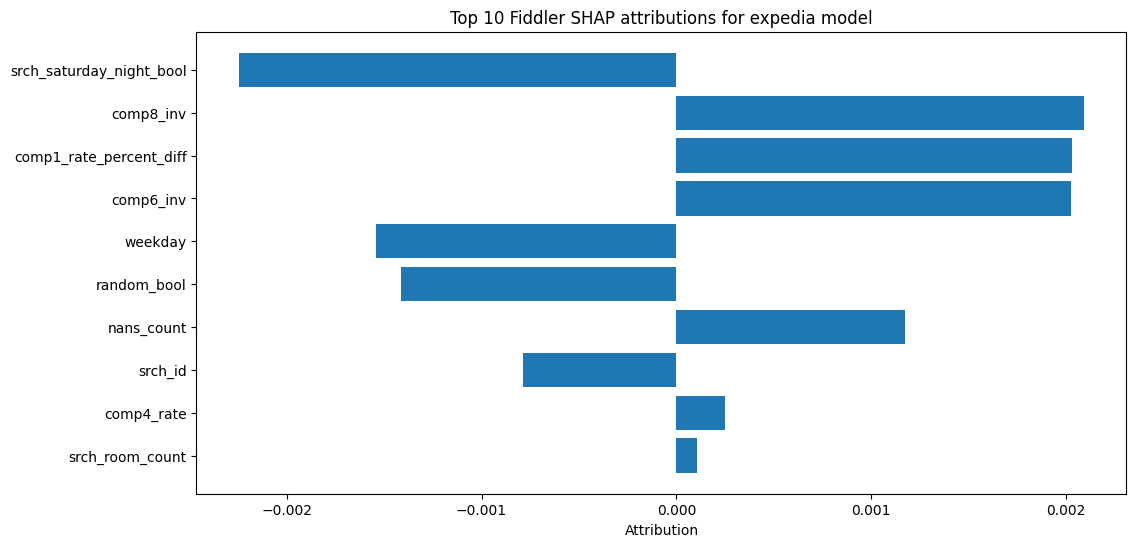

In [56]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

fig = plt.figure(figsize=(12, 6))
num_features = 10
sorted_att_list = sorted(list(zip(np.abs(fiddler_shap.attributions), fiddler_shap.inputs, fiddler_shap.attributions)),
                         reverse=True)
out_list = [[f[1], f[2]] for f in sorted_att_list]
out_list = np.asarray(out_list[::-1])

plt.barh(list(range(num_features)), out_list[:10,1].astype('float'))
plt.yticks(list(range(num_features)), out_list[:10,0]);
plt.xlabel('Attribution')
plt.title(f'Top 10 Fiddler SHAP attributions for expedia model')
plt.show()

# Send Monitoring Traffic

This is the production log file we are going to upload in Fiddler.

In [37]:
df_logs = pd.read_csv('../samples/datasets/expedia_ranking/expedia_logs.csv')
df_logs.head()

,srch_id,date_time,site_id,visitor_location_country_id,visitor_hist_starrating,visitor_hist_adr_usd,prop_country_id,prop_id,prop_starrating,prop_review_score,...,click_bool,weekday,week_of_year,hour_time,minute_time,time_epoch,early_night,nans_count,score,event_id
0,1672,2021-08-17 14:08:14,14,100,NaN,NaN,100,3674,2,4.5,...,0,3,25,14,8,1.371737e+09,False,27,-0.303444,0
1,1672,2021-08-17 14:08:14,14,100,NaN,NaN,100,21062,4,4.5,...,0,3,25,14,8,1.371737e+09,False,27,0.127730,1
2,1672,2021-08-17 14:08:14,14,100,NaN,NaN,100,29006,3,4.0,...,0,3,25,14,8,1.371737e+09,False,27,-2.540481,2
3,1672,2021-08-17 14:08:14,14,100,NaN,NaN,100,42013,3,4.0,...,0,3,25,14,8,1.371737e+09,False,27,-0.210803,3
4,1672,2021-08-17 14:08:14,14,100,NaN,NaN,100,43987,4,4.5,...,0,3,25,14,8,1.371737e+09,False,27,-1.249932,4


In [38]:
df_logs['event_id'] = df_logs['event_id'].apply(str)

For ranking, we need to ingest all events from a given Query ID together. To do that, we need to transform the data to a grouped format.  
You can use the `convert_flat_csv_data_to_grouped` utility function to do the transformation.


In [39]:
df_logs_grouped = fdl.utils.pandas.convert_flat_csv_data_to_grouped(input_data=df_logs, group_by_col='srch_id'

In [40]:
df_logs_grouped.head(2)

,srch_id,date_time,site_id,visitor_location_country_id,visitor_hist_starrating,visitor_hist_adr_usd,prop_country_id,prop_id,prop_starrating,prop_review_score,...,click_bool,weekday,week_of_year,hour_time,minute_time,time_epoch,early_night,nans_count,score,event_id
0,1672,"[2021-08-17 14:08:14, 2021-08-17 14:08:14, 202...","[14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 1...","[100, 100, 100, 100, 100, 100, 100, 100, 100, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[100, 100, 100, 100, 100, 100, 100, 100, 100, ...","[3674, 21062, 29006, 42013, 43987, 46288, 5611...","[2, 4, 3, 3, 4, 2, 4, 4, 4, 3, 3, 4, 4, 4, 2, ...","[4.5, 4.5, 4.0, 4.0, 4.5, 3.5, 4.5, 4.5, 4.0, ...",...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, ...","[25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 2...","[14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 1...","[8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, ...","[1371737294.0, 1371737294.0, 1371737294.0, 137...","[False, False, False, False, False, False, Fal...","[27, 27, 27, 27, 27, 28, 27, 27, 27, 28, 27, 2...","[-0.3034440189405202, 0.1277299190028656, -2.5...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
1,1673,"[2021-04-30 19:48:00, 2021-04-30 19:48:00, 202...","[5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, ...","[219, 219, 219, 219, 219, 219, 219, 219, 219, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[219, 219, 219, 219, 219, 219, 219, 219, 219, ...","[1811, 3271, 14798, 21219, 27421, 31773, 33138...","[2, 2, 2, 3, 3, 2, 4, 3, 3, 2, 3, 2, 2, 3, 3, ...","[4.5, 3.5, 4.0, 4.0, 4.5, 2.0, 4.0, 4.0, 4.0, ...",...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...","[5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, ...","[9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, ...","[19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 1...","[48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 4...","[1362253680.0, 1362253680.0, 1362253680.0, 136...","[False, False, False, False, False, False, Fal...","[17, 15, 20, 20, 14, 22, 17, 15, 17, 18, 19, 1...","[-0.2829261446329769, -0.97491992066589, -2.33...","[32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 4..."


Publish events

In [41]:
client.publish_events_batch(project_id=project_id,
                            model_id=model_id,
                            batch_source=df_logs_grouped,
                            id_field='event_id',
                            timestamp_field='date_time')

{'status': 202,
 'job_uuid': 'c9fb826d-5395-444a-bac6-e929ee88414f',
 'files': ['tmpxzcyz2h7.csv'],
 'message': 'Successfully received the event data. Please allow time for the event ingestion to complete in the Fiddler platform.'}